In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
from skimage import io
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import monai
from monai.networks import one_hot
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from utils.SurfaceDice import compute_dice_coefficient
from skimage import io, transform
from glob import glob
from sklearn.model_selection import train_test_split
import pandas as pd
import nibabel as nib
import pickle
from torch.utils.data import RandomSampler
import random
import scipy
import torch.nn.functional as F
import img2pdf
from torchmetrics import F1Score

from MedSAM_HCP.dataset import MRIDataset, load_datasets
from MedSAM_HCP.MedSAM import MedSAM, medsam_inference
from MedSAM_HCP.build_sam import build_sam_vit_b_multiclass
from MedSAM_HCP.utils_hcp import *

# set seeds
torch.manual_seed(2023)
np.random.seed(2023)

In [43]:
def show_anns(anns, axes=None, num_take = 10):
    # anns must be (103, 256, 256) np array of uint8

    np.random.seed(182)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    # remove index 0 corresponding to unknown label
    anns = anns[1:, :, :]

    tt = np.sum(anns == 1, axis=(1,2))
    idxs = np.argsort(-tt)
    idxs = idxs[:num_take]
    
    for ann_idx in range(num_take):
        take_idx = idxs[ann_idx]
        mask_arr = anns[take_idx,:,:]
        img = np.ones((mask_arr.shape[0], mask_arr.shape[1], 3)) # 256, 256, 3
        color_mask = np.random.random((1, 3)).tolist()[0] # list of floats of length 3
        for i in range(3):
            img[:,:,i] = color_mask[i]
        combined = np.dstack((img, mask_arr*0.5))
        ax.imshow(combined)
    ax.axis('off')



In [5]:
df_hcp = pd.read_csv('/gpfs/home/kn2347/MedSAM/hcp_mapping_processed.csv')
df_desired = pd.read_csv('/gpfs/home/kn2347/MedSAM/darts_name_class_mapping_processed.csv')
NUM_CLASSES = len(df_desired)
label_converter = LabelConverter(df_hcp, df_desired)

path_df_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/path_df_constant_bbox.csv'
train_test_splits_path = '/gpfs/data/luilab/karthik/pediatric_seg_proj/train_val_test_split.pickle'
train_dataset, val_dataset, test_dataset = load_datasets(path_df_path, train_test_splits_path, label_id = None, bbox_shift=0, sample_n_slices = None, label_converter= label_converter, NUM_CLASSES=NUM_CLASSES)


torch.Size([103, 256, 256])


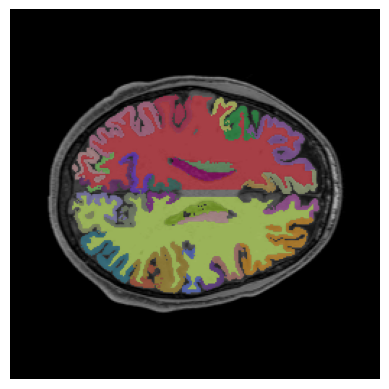

In [44]:


img_idx = 128
# show image first
img = np.repeat(train_dataset.load_image(img_idx)[:,:,None], 3, axis=-1)
plt.imshow(img)
show_anns(train_dataset[img_idx][1].numpy(), num_take = 30)
print(train_dataset[img_idx][1].shape)